# Text Summarization using BERT

### Dataset : 
Indian News Summary from https://www.kaggle.com/sunnysai12345/news-summary?select=news_summary.csv

The dataset consists of 4515 examples and contains Author_name, Headlines, Url of Article, Short text, Complete Article. I gathered the summarized news from Inshorts and only scraped the news articles from Hindu, Indian times and Guardian. Time period ranges from febrauary to august 2017.

### Model 
bert-small2bert-small-finetuned-cnn_daily_mail-summarization

https://huggingface.co/mrm8488/bert-small2bert-small-finetuned-cnn_daily_mail-summarization

## Loading Google Drive
Run if you're running this notebook on Google Colab to ease saving result process

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Load Packages

In [18]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords   

import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
import re           
from bs4 import BeautifulSoup 
pd.set_option("display.max_colwidth", 200)
import warnings
warnings.filterwarnings("ignore")

# DL Library
import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizerFast, EncoderDecoderModel
import torch

# Metrics
from rouge import Rouge

print("TensorFlow Version:",tf.__version__)
print("Keras Version:",keras.__version__)

TensorFlow Version: 2.7.0
Keras Version: 2.7.0


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JonathanK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load Data

### Option 1 : Retrieve data using Kaggle API

#### Upload Kaggle.json

**Run this code when using Google Colab**

You can get the file from Kaggle.com > Account > API > Create New API Token

In [ ]:
# only run this in google colab to upload data
from google.colab import files

print("Upload your kaggle.json")
uploaded = files.upload()

Upload your kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
# Copy the JSON file to root directory and change the file permission
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Download the Dataset

In [ ]:
!kaggle datasets download -d sunnysai12345/news-summary

 40% 8.00M/19.8M [00:00<00:00, 81.6MB/s]
100% 19.8M/19.8M [00:00<00:00, 127MB/s] 


Unzip the data

In [ ]:
!unzip news-summary.zip

Archive:  news-summary.zip
  inflating: news_summary.csv        
  inflating: news_summary_more.csv   


In [ ]:
dataset_path = "news_summary.csv"

### Option 2 : Load data locally

In [3]:
dataset_path = "Dataset/news_summary.csv"

## Load Data

In [4]:
original_data = pd.read_csv(dataset_path, encoding = "ISO-8859-1")
original_data.shape

(4514, 6)

In [5]:
data = pd.read_csv(dataset_path, encoding = "ISO-8859-1") 
print(data.shape)
data.sample(5)

(4514, 6)


,author,date,headlines,read_more,text,ctext
2646,Anmol Sharma,"09 Jul 2017,Sunday","PM seeks UK's help in return of Vijay Mallya, Lalit Modi",http://indiatoday.intoday.in/story/pm-seeks-uks-help-in-return-of-vijay-mallya-lalit-modi/1/997613.html,Prime Minister Narendra Modi on Saturday sought British PM Theresa May's help to ensure UK's cooperation to bring back economic offenders including fugitive liquor baron Vijay Mallya and former IP...,"(Eds: Updating with more quotes) By Barun Jha Hamburg, Jul 8 (PTI) Prime Minister Narendra Modi today pressed upon his British counterpart Theresa May to ensure UKs cooperation to bring back econo..."
769,Parmeet Kaur,"21 Jul 2017,Friday",Mumbai University results to be out by August after delays,http://www.hindustantimes.com/mumbai-news/mumbai-university-results-to-be-out-by-mid-august-teachers-say-glitches-are-delaying-assessment/story-NzvMzZgpWP5PV4JqSFPmFN.html?utm_source=inshorts&utm_...,"University of Mumbai (MU) hopes to declare the results of the examinations conducted this year between March and April by the second week of August, MU officials said. The university had adopted a...","After weeks of speculation, University of Mumbai officials said they hope to announce the results of major examinations conducted earlier this year, by second week of August. While they said they..."
537,Arshiya Chopra,"26 Jul 2017,Wednesday",PM Modi honours martyrs on 18th Kargil Vijay Diwas,http://indiatoday.intoday.in/story/kargil-vijay-diwas-pm-modi-kargil-war-1999-martyrs/1/1011000.html?utm_source=inshorts&utm_medium=referral&utm_campaign=fullarticle,"Prime Minister Narendra Modi on Wednesday took to Twitter to honour and pay tribute to the martyrs of Kargil war on the occasion of 18th Kargil Vijay Diwas. ""Kargil Vijay Diwas reminds us of India...","Honouring the Kargil martyrs today on 18th Vijay Diwas, Prime Minister Narendra Modi in a series of tweets lauded the gallantry of Indian military and paid tribute to the valiant soldiers of 1999 ..."
85,Saloni Tandon,"02 Aug 2017,Wednesday",India to play record 23 home matches in 4 months this year,http://www.hindustantimes.com/india-vs-sri-lanka-2017/india-may-have-two-new-venues-for-home-tests-against-sri-lanka/story-2Qs1zV50eXoRLJiACkvNtN.html?utm_source=inshorts&utm_medium=referral&utm_c...,"Team India will play a record 23 home matches this year from September to December, the BCCI announced on Tuesday. India will host Australia, New Zealand and Sri Lanka during the season, with the ...","Two new venues, Thiruvananthapuram in Kerala and Barsapara in Assam are in contention to host Test matches during the home series against Sri Lanka as Indian cricket team is set to play a record 2..."
2337,Parmeet Kaur,"15 Jul 2017,Saturday",Maha to pay farmers ?2.43 cr per acre for land acquisition,http://www.hindustantimes.com/mumbai-news/mumbai-nagpur-highway-maharashtra-to-pay-farmers-in-shahapur-2-43cr-per-acre/story-62OjBqrWWqvGDDhnfThNnM.html?utm_source=inshorts&utm_medium=referral&utm...,"The farmers in Khardi village in Thane will get a compensation of ?2.43 crore per acre from the Maharashtra government, for their land acquired for the Mumbai-Nagpur super communication highway pr...","In a move to stem farmers? protests against land acquisition for the ambitious Mumbai-Nagpur super communication highway, the state government seems to have opened its purse strings. This week, t..."


Drop duplicates and NA values

In [6]:
data.drop_duplicates(subset=['text'], inplace=True) 
data.dropna(axis=0, inplace=True)
data.shape

(4396, 6)

## Preprocessing

In [7]:
# Dictionary for expanding contracted words
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

### Text Cleaning
The process that we will do is :
- Convert all letter to lowercase
- Remove HTML tags
- Expand the contracted words
- Remove 's
- Remove any text inside parenthesis ()
- Eliminate punctuations and special characters
- Renove stopwords
- Remove short words

In [8]:
en_sw = set(stopwords.words('english'))
def text_preprocessing(text):
  # Convert all letter to lowercase
  cleanedStr = text.lower()
  # Remove HTML tags
  cleanedStr = BeautifulSoup(cleanedStr, "lxml").text
  # Remove Punctuation & special characters
  cleanedStr = re.sub(r'\([^)]*\)', '', cleanedStr)
  cleanedStr = re.sub('"', '', cleanedStr)
  # Expand Contracted Words
  cleanedStr = ' '.join([contraction_mapping[txt] if txt in contraction_mapping \
                         else txt for txt in cleanedStr.split(" ")])
  # Remove 's
  cleanedStr = re.sub(r"'s\b", '', cleanedStr)
  # Only take alphabet characters
  cleanedStr = re.sub("[^a-zA-Z]", " ", cleanedStr)
  # Tokenization
  tokens = [w for w in cleanedStr.split() if not w in en_sw]
  # Only take the text with more than 3 words
  long_words  = []
  for i in tokens:
    if len(i) >= 3:
      long_words.append(i)
  
  return (" ".join(long_words)).strip()

In [9]:
cleaned_text = []
for txt in data['ctext']:
  cleaned_text.append(text_preprocessing(txt))

print(len(cleaned_text))
cleaned_text[0:10]

4396


['daman diu administration wednesday withdrew circular asked women staff tie rakhis male colleagues order triggered backlash employees ripped apart social media union territory administration forced retreat within hours issuing circular made compulsory staff celebrate rakshabandhan workplace decided celebrate festival rakshabandhan august connection offices departments shall remain open celebrate festival collectively suitable time wherein lady staff shall tie rakhis colleagues order issued august gurpreet singh deputy secretary said ensure one skipped office attendance report sent government next evening two notifications one mandating celebration rakshabandhan withdrawing mandate issued daman diu administration day apart circular withdrawn one line order issued late evening department personnel administrative reforms circular ridiculous sensitivities involved government dictate tie rakhi maintain professionalism workplace official told hindustan times earlier day refused identified n

### Summary Cleaning

In [10]:
data['text'][:10]

0    The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The...
1    Malaika Arora slammed an Instagram user who trolled her for "divorcing a rich man" and "having fun with the alimony". "Her life now is all about wearing short clothes, going to gym or salon, enjoy...
2    The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna on Thursday made corrections in its Marital Declaration Form by changing 'Virgin' option to 'Unmarried'. Earlier, Bihar Health Mini...
3    Lashkar-e-Taiba's Kashmir commander Abu Dujana, who was killed by security forces, said "Kabhi hum aage, kabhi aap, aaj aapne pakad liya, mubarak ho aapko (Today you caught me. Congratulations)" a...
4    Hotels in Maharashtra will train their staff to spot signs of sex trafficking, including frequent requests for bed linen changes and 'Do not disturb' signs left on room doors 

In [11]:
#Call the above function
cleaned_summary = []
for t in data['text']:
    cleaned_summary.append(text_preprocessing(t))

cleaned_summary[:10]

['administration union territory daman diu revoked order made compulsory women tie rakhis male colleagues occasion rakshabandhan august administration forced withdraw decision within hours issuing circular received flak employees slammed social media',
 'malaika arora slammed instagram user trolled divorcing rich man fun alimony life wearing short clothes going gym salon enjoying vacation user commented malaika responded certainly got get damn facts right spewing know nothing',
 'indira gandhi institute medical sciences patna thursday made corrections marital declaration form changing virgin option unmarried earlier bihar health minister defined virgin unmarried woman consider term objectionable institute however faced strong backlash asking new recruits declare virginity form',
 'lashkar taiba kashmir commander abu dujana killed security forces said kabhi hum aage kabhi aap aaj aapne pakad liya mubarak aapko caught added surrender whatever fate happen hum nikley shaheed hone added',
 

In [12]:
# Insert data to dataframe
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
print(data.shape)

# Drop Empty Rows
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

(4396, 8)


In [13]:
print(data.shape)
data.head(5)

(4396, 8)


,author,date,headlines,read_more,text,ctext,cleaned_text,cleaned_summary
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in offices order,http://www.hindustantimes.com/india-news/rakshabandhan-compulsory-in-daman-and-diu-women-employees-to-tie-rakhis-to-male-colleagues/story-E5h5U1ZDJii5zFpLXWRkhJ.html?utm_source=inshorts&utm_medium...,The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The...,The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart o...,daman diu administration wednesday withdrew circular asked women staff tie rakhis male colleagues order triggered backlash employees ripped apart social media union territory administration forced...,administration union territory daman diu revoked order made compulsory women tie rakhis male colleagues occasion rakshabandhan august administration forced withdraw decision within hours issuing c...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorcing rich man',http://www.hindustantimes.com/bollywood/malaika-arora-khan-was-trolled-for-divorcing-a-rich-man-her-reply-is-dignity-itself/story-oIPZNI9deImCmabLMMwR2H.html?utm_source=inshorts&utm_medium=referra...,"Malaika Arora slammed an Instagram user who trolled her for ""divorcing a rich man"" and ""having fun with the alimony"". ""Her life now is all about wearing short clothes, going to gym or salon, enjoy...","From her special numbers to TV?appearances, Bollywood actor Malaika Arora Khan has managed to carve her own identity. The actor, who made her debut in the Hindi film industry with the blockbuster ...",special numbers appearances bollywood actor malaika arora khan managed carve identity actor made debut hindi film industry blockbuster debut opposite shah rukh khan chaiyya chaiyya dil still remem...,malaika arora slammed instagram user trolled divorcing rich man fun alimony life wearing short clothes going gym salon enjoying vacation user commented malaika responded certainly got get damn fac...
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS' form,http://www.hindustantimes.com/patna/bihar-igims-form-loses-virginity-after-row-opts-for-unmarried-instead/story-8XmHIg39otGBoZAYEBQxMK.html?utm_source=inshorts&utm_medium=referral&utm_campaign=ful...,"The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna on Thursday made corrections in its Marital Declaration Form by changing 'Virgin' option to 'Unmarried'. Earlier, Bihar Health Mini...","The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna amended its marital declaration form on Thursday, replacing the word ?virgin? with ?unmarried? after controversy.Until now, new rec...",indira gandhi institute medical sciences patna amended marital declaration form thursday replacing word virgin unmarried controversy new recruits super specialty medical institute state capital re...,indira gandhi institute medical sciences patna thursday made corrections marital declaration form changing virgin option unmarried earlier bihar health minister defined virgin unmarried woman cons...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before being killed,http://indiatoday.intoday.in/story/abu-dujana-last-phone-call-lashkar-e-taiba-jammu-and-kashmir/1/1017550.html?utm_source=inshorts&utm_medium=referral&utm_campaign=fullarticle,"Lashkar-e-Taiba's Kashmir commander Abu Dujana, who was killed by security forces, said ""Kabhi hum aage, kabhi aap, aaj aapne pakad liya, mubarak ho aapko (Today you caught me. Congratulations)"" a...","Lashkar-e-Taiba's Kashmir commander Abu Dujana was killed in an encounter in a village in Pulwama district of Jammu and Kashmir earlier this week. D

## Exploratory Data Analysis
Understanding the distribution of text sequence

We want to analyze the length of revieiws and summary to get an idea of the distribution of length of the sequence

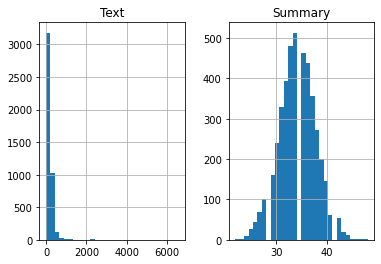

In [14]:
text_word_count = []
summary_word_count = []

# Populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Text':text_word_count, 'Summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

Calculating the proportion of text

In [15]:
count = 0
for i in data['cleaned_text']:
  if(len(i.split()) <= 350):
    count = count+1
print(count/len(data['cleaned_text']))

0.9212920837124658


Calculating the proportion of summary

In [16]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=40):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9645131938125568


We can observe that 94% of the summaries have length below 8. So, we can fix maximum length of summary to 8

## Generate Summary Function

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('mrm8488/bert-small2bert-small-finetuned-cnn_daily_mail-summarization')
model = EncoderDecoderModel.from_pretrained('mrm8488/bert-small2bert-small-finetuned-cnn_daily_mail-summarization')

In [24]:
def generate_summary(text):
    # Cut off at BERT max length 512
    inputs = tokenizer([text], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask

    output = model.generate(input_ids, attention_mask=attention_mask)

    return tokenizer.decode(output[0], skip_special_tokens=True)

## Generate Summary

In [25]:
# Ground Truth
original_summary = []
for t in data['text']:
    original_summary.append(t)
original_summary

['The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media.',
 'Malaika Arora slammed an Instagram user who trolled her for "divorcing a rich man" and "having fun with the alimony". "Her life now is all about wearing short clothes, going to gym or salon, enjoying vacation[s]," the user commented. Malaika responded, "You certainly got to get your damn facts right before spewing sh*t on me...when you know nothing about me."',
 "The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna on Thursday made corrections in its Marital Declaration Form by changing 'Virgin' option to 'Unmarried'. Earlier, Bihar Health Minister defined virgin as being an unmarried woman and did not consider the 

In [26]:
output_summary = []
for idx, txt in enumerate(cleaned_text):
  print("Text -", idx)
  res = generate_summary(txt)
  output_summary.append(res)

len(output_summary)

Text - 0
Text - 1
Text - 2
Text - 3
Text - 4
Text - 5
Text - 6
Text - 7
Text - 8
Text - 9
Text - 10
Text - 11
Text - 12
Text - 13
Text - 14
Text - 15
Text - 16
Text - 17
Text - 18
Text - 19
Text - 20
Text - 21
Text - 22
Text - 23
Text - 24
Text - 25
Text - 26
Text - 27
Text - 28
Text - 29
Text - 30
Text - 31
Text - 32
Text - 33
Text - 34
Text - 35
Text - 36
Text - 37
Text - 38
Text - 39
Text - 40
Text - 41
Text - 42
Text - 43
Text - 44
Text - 45
Text - 46
Text - 47
Text - 48
Text - 49
Text - 50
Text - 51
Text - 52
Text - 53
Text - 54
Text - 55
Text - 56
Text - 57
Text - 58
Text - 59
Text - 60
Text - 61
Text - 62
Text - 63
Text - 64
Text - 65
Text - 66
Text - 67
Text - 68
Text - 69
Text - 70
Text - 71
Text - 72
Text - 73
Text - 74
Text - 75
Text - 76
Text - 77
Text - 78
Text - 79
Text - 80
Text - 81
Text - 82
Text - 83
Text - 84
Text - 85
Text - 86
Text - 87
Text - 88
Text - 89
Text - 90
Text - 91
Text - 92
Text - 93
Text - 94
Text - 95
Text - 96
Text - 97
Text - 98
Text - 99
Text - 100

4396

In [27]:
# Output Summary
output_summary

['daman diu administration wednesday withdrew circular asked women staff tie rakhis male colleagues order issued late evening department personnel administrative reforms circular made compulsory staff celebrate rakshabandhan august connection offices departments shall remain open celebrate festival collectively suitable time for lady staff shall tie raksmen order issued august gurpreet singh deputy secretary said ensure one skipped office attendance report sent government next evening two notifications one mandating celebration rakhi.',
 'malaika arora shared gorgeous picture instagram follower decided troll using alumni money wear short clothes going gym salon little know munni badnam star would reply perfect comeback take look interaction super excited affiliated khanna jewellers khannajewellerskj brand ambassador crafted perfection stunning statement jewellery must every jewellery lover khannajajeweller maksquad hair hairbypriyanka stylist manekaharisinghani manager ektakaurober sug

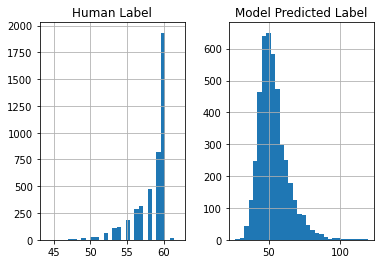

In [28]:
human_label = []
model_predicted_label = []

# populate the lists with sentence lengths
for i in original_summary:
      human_label.append(len(i.split()))

for i in output_summary:
      model_predicted_label.append(len(i.split()))

length_df = pd.DataFrame({'Human Label':human_label, 'Model Predicted Label':model_predicted_label})
length_df.hist(bins = 30)
plt.show()

In [29]:
rouge = Rouge()

In [30]:
rouge.get_scores(output_summary, original_summary, avg=True)

{'rouge-1': {'f': 0.1872165969032017,
  'p': 0.20095265815291272,
  'r': 0.17904381306627096},
 'rouge-2': {'f': 0.03288070976516855,
  'p': 0.035224103345257454,
  'r': 0.031305818486174815},
 'rouge-l': {'f': 0.17028223492277073,
  'p': 0.18297111637175895,
  'r': 0.16268534166413817}}

## Output Text

In [31]:
final_result_df = pd.DataFrame()
final_result_df['Human Summary'] = original_summary
final_result_df['Model Predicted Summary'] = output_summary

In [33]:
output_path = "drive/MyDrive/SmallBERT_Output/SmallBERT_result.csv"
final_result_df.to_csv(output_path)